[Info dataset Youtube8M](https://www.kaggle.com/competitions/youtube8m-2019)

**frame-level data** <br>
You may download to your local computer with instructions here
Total size of 1.53TB (Large file warning!)
Each video has:

- id: unique id for the video, in train set it is a YouTube video id, and in test/validation they are anonymized.
- labels: list of labels of that video.
- Each frame has rgb: float array of length 1024,
- Each frame has audio: float array of length 128


Files are in TFRecords format, TensorFlow python readers are available in the github repo.
frame-sample.zip - a sample of frame-level data including train00 and train01

validate-sample.zip - a sample of validation set data including validate00 and validate01

vocabulary.csv - the full data dictionary for label names and their descriptions

sample_submission.csv - a sample submission file in the correct format


In [1]:
import os
import sys
import numpy as np
import pandas as pd
from pathlib import Path
import tensorflow.compat.v1 as tf

# add root path
PATH_ROOT = Path.cwd()
for _ in range(6):
    last_files = os.listdir(PATH_ROOT)
    if 'src' in last_files:
        break
    else:
        PATH_ROOT = PATH_ROOT.parent
sys.path.append(PATH_ROOT.__str__())

# Local imports
from utils.utils import Map_index2label

#### Note: 
only the validation data contains the segment start and times and segment labels

In [50]:
# Define path data
FOLDER_DATA = Path('../data/raw/yt8m_2nd')

PATH_VOCABULARY = FOLDER_DATA / 'vocabulary.csv'

PATH_LABELS_NAMES = FOLDER_DATA / 'label_names_2018.csv'

# Features for frame level
PATH_TF_TRAIN_FRAME_LEVEL_00 = (FOLDER_DATA / 'frame_sample' / 'train00.tfrecord').__str__()
PATH_TF_TRAIN_FRAME_LEVEL_01 = (FOLDER_DATA / 'frame_sample' / 'train01.tfrecord').__str__()

# Features for video level
PATH_TF_TRAIN_VIDEO_LEVEL_00 = (FOLDER_DATA / 'video_sample' / 'train00.tfrecord').__str__()
PATH_TF_TRAIN_VIDEO_LEVEL_01 = (FOLDER_DATA / 'video_sample' / 'train01.tfrecord').__str__()


In [51]:
get_label_videos = lambda x: [tf.train.Example.FromString(example).features.feature['labels'].int64_list.value for example in tf.python_io.tf_record_iterator(x)]

print(f"Number of videos in train00.tfrecord:       {len(get_label_videos(PATH_TF_TRAIN_FRAME_LEVEL_00))}")
print(f"Number of videos in train01.tfrecord:       {len(get_label_videos(PATH_TF_TRAIN_FRAME_LEVEL_01))}")
print(f"Number of videos in train00.tfrecord:       {len(get_label_videos(PATH_TF_TRAIN_VIDEO_LEVEL_00))}")
print(f"Number of videos in train01.tfrecord:       {len(get_label_videos(PATH_TF_TRAIN_VIDEO_LEVEL_01))}")

Number of videos in train00.tfrecord:       1015
Number of videos in train01.tfrecord:       1041
Number of videos in train00.tfrecord:       1015
Number of videos in train01.tfrecord:       1041


## Explore tfrecord
    * labels(list): target, # list of index   
    * id(str): video id
    * audio_embedding_numpy(array): audio embedding for the first frame, shape: (128,) | min: 0 , max: 255
    * rgb_embedding_numpy(array): rgb embedding for the first frame, shape: (1024,) | min: 0 , max: 255
    
    only for video feature data:
    * mean_audio_embedding_numpy(array): audio embedding for the first frame, shape: (128,) | min: 0 , max: 255
    * mean_rgb_embedding_numpy(array): rgb embedding for the first frame, shape: (1024,) | min: 0 , max: 255

In [75]:
# define function transform bytes 2 array
f_bytes2array = lambda x: tf.cast(tf.decode_raw( x.bytes_list.value[0], tf.uint8), tf.float32).numpy()
# instance mapping inde 2 labels
map_index2label = Map_index2label(PATH_VOCABULARY)

def get_info_1st_video(PATH_TF):
    """ Explore tfrecord for the first video
    Args:
        PATH_TF (str): path of tfrecord

    Features:
        labels(list): target, # list of index   
        id(str): video id
        audio_embedding_numpy(array): audio embedding for the first frame, shape: (128,)
        rgb_embedding_numpy(array): rgb embedding for the first frame, shape: (1024,)
        
        only for validation data:
        mean_audio_embedding_numpy(array): audio embedding for the first frame, shape: (128,)
        mean_rgb_embedding_numpy(array): rgb embedding for the first frame, shape: (1024,)
    """
    for example in tf.python_io.tf_record_iterator(PATH_TF):
        # get data for the video 
        tf_example = tf.train.SequenceExample.FromString(example)
        
        # Only for video level feature
        mean_audio_embedding_numpy = np.array(tf_example.context.feature['mean_audio'].float_list.value)    # shape: (128,)
        mean_rgb_embedding_numpy = np.array(tf_example.context.feature['mean_rgb'].float_list.value)      # shape: (1024,)

        # get index labels for the video
        labels =  tf_example.context.feature['labels'].int64_list.value # list of index

        # get id video
        id = tf_example.context.feature['id'].bytes_list.value[0].decode(encoding='UTF-8') # str
        
        # get  audio and rgb embeddings
        audio_embedding_bytes =  tf_example.feature_lists.feature_list['audio'].feature # len() # number of frames
        rgb_embedding_bytes =  tf_example.feature_lists.feature_list['rgb'].feature     # len() # number of frames

        # get number of frames of video
        N_FRAMES_VIDEO = len(audio_embedding_bytes)

        # only take the embedding for the first frame
        if len(audio_embedding_bytes) == 0:
            audio_embedding_numpy = mean_audio_embedding_numpy
            rgb_embedding_numpy = mean_rgb_embedding_numpy
        else:
            audio_embedding_numpy = f_bytes2array( audio_embedding_bytes[0] ) # shape: (128,)
            rgb_embedding_numpy = f_bytes2array( rgb_embedding_bytes[0] ) # shape: (1024,)
        
        break # just for exploring the data of the first video

    print(f"Get data from 1st video ({PATH_TF}):\n------------------------------------")
    print(f"ID VIDEO:                       {id}")
    print(f"Number of frames:               {N_FRAMES_VIDEO}")
    print(f"Label index video:              {labels}")
    print(f"Names labels:                   {[map_index2label(index) for index in labels]}")
    print(f"Shape video embedding:          {rgb_embedding_numpy.shape}")
    print(f"Shape audio embedding:          {audio_embedding_numpy.shape}")
    print(f"Shape mean video embedding:     {mean_rgb_embedding_numpy.shape}")
    print(f"Shape mean adio embedding:      {mean_audio_embedding_numpy.shape}")
    print('\n')

get_info_1st_video(PATH_TF_TRAIN_VIDEO_LEVEL_00)
get_info_1st_video(PATH_TF_TRAIN_FRAME_LEVEL_00)

Get data from 1st video (../data/raw/yt8m_2nd/video_sample/train00.tfrecord):
------------------------------------
ID VIDEO:                       4M00
Number of frames:               0
Label index video:              [26, 466]
Names labels:                   ['Toy', 'Littlest Pet Shop']
Shape video embedding:          (1024,)
Shape audio embedding:          (128,)
Shape mean video embedding:     (1024,)
Shape mean adio embedding:      (128,)


Get data from 1st video (../data/raw/yt8m_2nd/frame_sample/train00.tfrecord):
------------------------------------
ID VIDEO:                       op00
Number of frames:               234
Label index video:              [82, 103, 346, 350]
Names labels:                   ['Winter sport', 'Ice skating', 'Ice dancing', 'Figure skating']
Shape video embedding:          (1024,)
Shape audio embedding:          (128,)
Shape mean video embedding:     (0,)
Shape mean adio embedding:      (0,)




# Label names

In [124]:
df_labels2index = pd.read_csv( PATH_LABELS_NAMES )
label_mapping = pd.read_csv(PATH_LABELS_NAMES,header=0,index_col=0,squeeze=True).T.to_dict()
df_labels2index.head()

,label_id,label_name
0,0,Game
1,1,Vehicle
2,2,Video game
3,3,Concert
4,4,Car


# Vocabulary

In [93]:
vocabulary_df = pd.read_csv(PATH_VOCABULARY)
print(vocabulary_df.shape)
vocabulary_df.head()

(3862, 9)


,Index,TrainVideoCount,KnowledgeGraphId,Name,WikiUrl,Vertical1,Vertical2,Vertical3,WikiDescription
0,0,788288,/m/03bt1gh,Game,https://en.wikipedia.org/wiki/Game,Games,NaN,NaN,"A game is structured form of play, usually und..."
1,1,539945,/m/01mw1,Video game,https://en.wikipedia.org/wiki/Video_game,Games,NaN,NaN,A video game is an electronic game that involv...
2,2,415890,/m/07yv9,Vehicle,https://en.wikipedia.org/wiki/Vehicle,Autos & Vehicles,NaN,NaN,A vehicle is a mobile machine that transports ...
3,3,378135,/m/01jddz,Concert,https://en.wikipedia.org/wiki/Concert,Arts & Entertainment,NaN,NaN,A concert is a live music performance in front...
4,4,286532,/m/09jwl,Musician,https://en.wikipedia.org/wiki/Musician,Arts & Entertainment,NaN,NaN,A musician is a person who plays a musical ins...


In [77]:
unique_class = vocabulary_df['Index'].unique()
unique_vertiacal1 = vocabulary_df['Vertical1'].unique()
unique_vertiacal2 = vocabulary_df['Vertical2'].unique()
unique_vertiacal3 = vocabulary_df['Vertical3'].unique()

classes_verticals = list(unique_vertiacal1) + list(unique_vertiacal2) + list(unique_vertiacal3)
total_clases = np.unique(classes_verticals + list(unique_class))
N_CLASSES = len( unique_class )
N_CLASSES_VERTICAL = len( classes_verticals )
print(f"Number of classes:                      {N_CLASSES}")
print(f"Number of classes verticals:            {N_CLASSES_VERTICAL}") # some verticals classes are in CLASESS
print(f"Number of unique classes + verticals:   {len(total_clases)}")

Number of classes:                      3862
Number of classes verticals:            62
Number of unique classes + verticals:   3888


In [94]:
vocabulary_df
vocabulary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3862 entries, 0 to 3861
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Index             3862 non-null   int64 
 1   TrainVideoCount   3862 non-null   int64 
 2   KnowledgeGraphId  3862 non-null   object
 3   Name              3806 non-null   object
 4   WikiUrl           3806 non-null   object
 5   Vertical1         3862 non-null   object
 6   Vertical2         584 non-null    object
 7   Vertical3         32 non-null     object
 8   WikiDescription   3806 non-null   object
dtypes: int64(2), object(7)
memory usage: 271.7+ KB


# Explore categories
## top 30 categories

In [127]:
# Get top n classes
from collections import Counter
label_mapping = vocabulary_df[['Index', 'Name']].set_index('Index', drop=True).to_dict()['Name'] # dict: key --> index,  values --> name of category | len(): number of categories

n = 10
labels = get_label_videos(PATH_TF_TRAIN_VIDEO_LEVEL_00)
top_n = Counter([item for sublist in labels for item in sublist]).most_common(n) # tuple --> (index, num_samples)
top_n_labels = [int(i[0]) for i in top_n]   # list: top n index 
top_n_label_names = [label_mapping[x] for x in top_n_labels if x in label_mapping] # filter out the labels that aren't in the 1,000 used for this competition

print(f"Most {n} frequent categories:\n",top_n_label_names)

Most 10 frequent categories:
 ['Game', 'Video game', 'Vehicle', 'Concert', 'Musician', 'Cartoon', 'Car', 'Performance art', 'Association football', 'Musical ensemble']


# Distribution of classes

In [140]:
samples_per_name = [vocabulary_df[vocabulary_df['Name']==n]['TrainVideoCount'].sum() for n in top_n_label_names]
import plotly.graph_objects as go
fig = go.Figure(data=[go.Bar(x=top_n_label_names, y=samples_per_name)])
fig.layout['title'] = "Samples per categories"
fig.show()

## Node conections

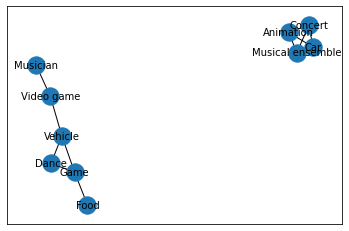

In [136]:
import networkx as nx
from itertools import combinations

G=nx.Graph()

# Get labels
labels = []
for example in tf.python_io.tf_record_iterator(PATH_TF_TRAIN_FRAME_LEVEL_00):
    tf_example = tf.train.Example.FromString(example)
    labels.append(tf_example.features.feature['labels'].int64_list.value)

# Create graph
G.clear()
for list_of_nodes in labels:
    filtered_nodes = set(list_of_nodes).intersection(set(top_n_labels))  
    for node1,node2 in list(combinations(filtered_nodes,2)): 
        node1_name = label_mapping[node1]
        node2_name = label_mapping[node2]
        G.add_node(node1_name)
        G.add_node(node2_name)
        G.add_edge(node1_name, node2_name)

nx.draw_networkx(G,font_size="10")